In [82]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import re
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# My attempt on titnaic problem from Kaggle
# https://www.kaggle.com/competitions/titanic/overview
# with minimal/occaasional reference from:
# https://www.kaggle.com/code/startupsci/titanic-data-science-solutions
# https://www.analyticsvidhya.com/blog/2021/10/implementing-artificial-neural-networkclassification-in-python-from-scratch/
#
# Code to predict who survived in titanic sinking


## Get data and try to see data

In [2]:
#Get Data
train_dataset = pd.read_csv("./train.csv", na_values='?', comment='\t', sep=',', skipinitialspace=True)
test_dataset = pd.read_csv("./test.csv", na_values='?', comment='\t', sep=',', skipinitialspace=True)

#Check Columns/Features
print(train_dataset.columns.values)
print(test_dataset.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']
['PassengerId' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare'
 'Cabin' 'Embarked']


In [3]:
train_dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#Check info, eg. which have NaN (In this case Age, Cabin, Embarked)
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
test_dataset.info() 
#Age, Fare, Cabin


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [6]:
train_dataset.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Data "cleaning"? 
1. Try to make new data from existing one
2. Fill in empty rows

In [272]:
#Data "cleaning"(?) 
# Get new data from existing data 
# fill NaN data
train_dataset = pd.read_csv("./train.csv", na_values='?', comment='\t', sep=',', skipinitialspace=True)
test_dataset = pd.read_csv("./test.csv", na_values='?', comment='\t', sep=',', skipinitialspace=True)
combine = [train_dataset,test_dataset]

#GET DATA AGAIN lol
def restartdata():


    for dataset in combine:
        #Family Size
        dataset["FamSize"]=dataset["SibSp"]+dataset["Parch"]

        #Alone or not
        dataset["Alone"] =  (dataset["FamSize"]  == 0)

        #Fill in the blanks
        dataset["Age"] = dataset["Age"].fillna(value=-1)
        dataset["Embarked"] = dataset["Embarked"].fillna(value="-")
        dataset["Fare"] = dataset["Fare"].fillna(value=-1)
        dataset["Cabin"] =  dataset["Cabin"].fillna(value=0)

        # Update Cabin Data
        dataset["CabinGroup"] = dataset["Cabin"].str.replace('\d+', '')
        #print(dataset["CabinGroup"].unique())
    #    Cabingroup = ["A", "B", "C", "D", "E", "F", "G", "T"]
    #    for i in Cabingroup:
    #        dataset[i] =     dataset["CabinGroup"].str.count(i)
    #        dataset[i] =     dataset[i].fillna(value=0)
    #        #print(dataset[[i, "Survived"]].groupby([i], as_index=False).mean().sort_values(by='Survived', ascending=False))

        #Number of Cabin
        dataset["NumOfCabin"] = dataset["CabinGroup"].str.split(" ").str.len()
        dataset["NumOfCabin"] = dataset["NumOfCabin"].fillna(value=0)

        #Ticket Number
        dataset['TicketNum']= dataset["Ticket"].str.split(" ").str[-1]
        dataset ['TicketNum'] = pd.to_numeric(dataset['TicketNum'], errors='coerce')
        dataset ['TicketNum'] = dataset['TicketNum'].replace(np.nan, -1, regex=True)

        #Name
        dataset["First Name"] = dataset['Name'].str.split(",").str[0]
        dataset["Last Name"] = dataset['Name'].str.split(",").str[-1].str.split(".").str[-1].str.split(" ").str[-1]
        #dataset.loc[dataset['Name'].str.split(",").str.len() == 2, 'Last Name'] = dataset['Name'].str.split(",").str[-1].str.split(".").str[-1]


        #Title
        dataset.loc[dataset['Name'].str.split(",").str.len() == 2, 'Title'] = dataset['Name'].str.split(",").str[-1].str.split(".").str[0]
        dataset["Title"] = dataset["Title"].replace(" Ms", " Miss")
        dataset['Title'] = dataset['Title'].replace([' Lady', ' Countess',' Capt', ' Col', 	' Don', ' Dr', ' Major', ' Rev', ' Sir', ' Jonkheer', ' Dona'], 'Rare')
        dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
        dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
        dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
restartdata()

/tmp/ipykernel_514997/2623662938.py:26: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset["CabinGroup"] = dataset["Cabin"].str.replace('\d+', '')
/tmp/ipykernel_514997/2623662938.py:26: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset["CabinGroup"] = dataset["Cabin"].str.replace('\d+', '')


In [273]:
train_dataset = train_dataset.drop(["Name","First Name","Last Name","Cabin","CabinGroup","Ticket","PassengerId"],axis=1)
test_dataset = test_dataset.drop(["Name","First Name","Last Name","Cabin","CabinGroup","Ticket","PassengerId"],axis=1)
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    object 
 3   Age         891 non-null    float64
 4   SibSp       891 non-null    int64  
 5   Parch       891 non-null    int64  
 6   Fare        891 non-null    float64
 7   Embarked    891 non-null    object 
 8   FamSize     891 non-null    int64  
 9   Alone       891 non-null    bool   
 10  NumOfCabin  891 non-null    float64
 11  TicketNum   891 non-null    float64
 12  Title       891 non-null    object 
dtypes: bool(1), float64(4), int64(5), object(3)
memory usage: 84.5+ KB


In [8]:

##Try to see any correlation with the initials and survival rate


#train_dataset["F"] =  train_dataset['First Name'].str[0].sort_values().reset_index(drop=True)
#train_dataset["L"] =  train_dataset['Last Name'].str[0].sort_values().reset_index(drop=True)
#with pd.option_context('display.max_rows', None,):
#   print(train_dataset[['F', "Survived"]].groupby(["F"], as_index=False).mean().sort_values(by='Survived', ascending=False).head(100))
#   print(train_dataset[['L', "Survived"]].groupby(["L"], as_index=False).mean().sort_values(by='Survived', ascending=False).head(100))
#
#g = sns.FacetGrid(train_dataset,col="Survived",size=10)
#g.map(sns.histplot, "L")
#plt.show()
#
#g = sns.FacetGrid(train_dataset,col="Survived",size=10)
#g.map(sns.histplot, "F")
#plt.show()


##-> not really, only see how common names are generally


# Visualization of data to find some correlation between datas

   Alone  Survived
0  False  0.505650
1   True  0.303538


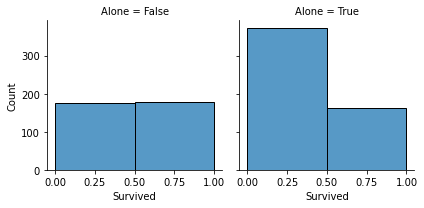

In [520]:
print(train_dataset[['Alone', "Survived"]].groupby(["Alone"], as_index=False).mean().sort_values(by='Survived', ascending=False))
g = sns.FacetGrid(train_dataset, col='Alone')
g.map(sns.histplot, "Survived",bins=2)
plt.show()

#If youre alone, youre more likely to die, sad life
#If youre not alone,  its still 50 50 man
# As a wise ape once said, "Ape together strong"

      Sex  Survived
0  female  0.742038
1    male  0.188908


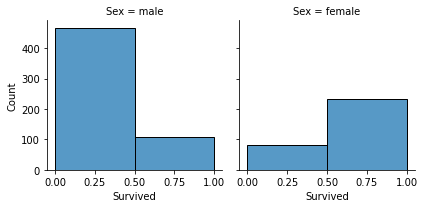

In [519]:
print(train_dataset[['Sex', "Survived"]].groupby(["Sex"], as_index=False).mean().sort_values(by='Survived', ascending=False))
g = sns.FacetGrid(train_dataset, col='Sex')
g.map(sns.histplot, "Survived",bins=2)
plt.show()
#More likely to die youre a man

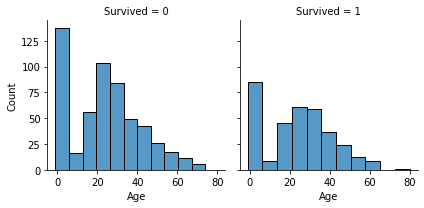

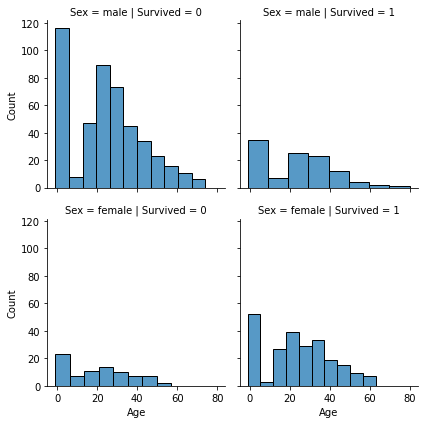

In [29]:
#Visualize some data to get some idea
g = sns.FacetGrid(train_dataset, col='Survived')
g.map(sns.histplot, "Age")
plt.show()

g = sns.FacetGrid(train_dataset, col='Survived',row='Sex')
g.map(sns.histplot, "Age")
plt.show()

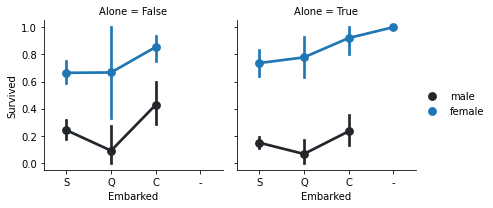

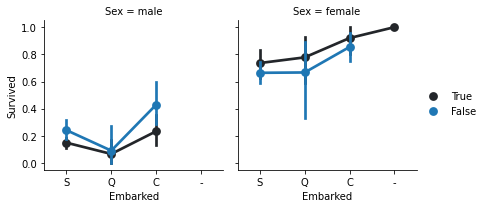

In [30]:
g = sns.FacetGrid(train_dataset, col="Alone")
g.map(sns.pointplot, 'Embarked',"Survived", "Sex", order=["S","Q","C","-"],hue_order=["male","female"])
g.add_legend()
plt.show()

g = sns.FacetGrid(train_dataset, col="Sex")
g.map(sns.pointplot, 'Embarked',"Survived", "Alone", order=["S","Q","C","-"],hue_order=[True,False])
g.add_legend()
plt.show()
#Somehow if youre a man and youre alone, you die more easily
#but if youre a woman and youre alone, you more likely to survived?


/home/ys/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


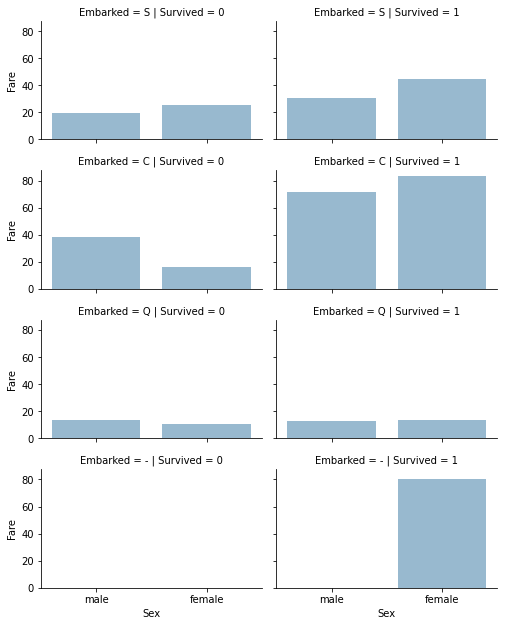

In [31]:
# grid = sns.FacetGrid(train_df, col='Embarked', hue='Survived', palette={0: 'k', 1: 'w'})
grid = sns.FacetGrid(train_dataset, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None,order=["male","female"])
grid.add_legend()

# ANN building

In [500]:
#Reclean data (too lazy to scroll up) 
# Poor coding practice actually, need to find ways to write better 
train_dataset = pd.read_csv("./train.csv", na_values='?', comment='\t', sep=',', skipinitialspace=True)
test_dataset = pd.read_csv("./test.csv", na_values='?', comment='\t', sep=',', skipinitialspace=True)
combine = [train_dataset,test_dataset]

restartdata()

train_dataset = train_dataset.drop(["Name","First Name","Last Name","Cabin","CabinGroup","Ticket","PassengerId"],axis=1)
test_dataset = test_dataset.drop(["Name","First Name","Last Name","Cabin","CabinGroup","Ticket","PassengerId"],axis=1)

/tmp/ipykernel_514997/2623662938.py:26: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset["CabinGroup"] = dataset["Cabin"].str.replace('\d+', '')
/tmp/ipykernel_514997/2623662938.py:26: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset["CabinGroup"] = dataset["Cabin"].str.replace('\d+', '')


In [501]:
from sklearn.model_selection import train_test_split
#train_dataset.info()
train_features = train_dataset.drop(["Survived"],axis=1)
train_label = train_dataset["Survived"]

# change obejct columns to separate columns
object_index = list(map(train_features.columns.get_loc, train_features.select_dtypes(include=['object']).columns))
ct =ColumnTransformer(transformers=[('encoder',OneHotEncoder(),object_index)],remainder="passthrough")
train_features = sc.fit_transform(np.array(ct.fit_transform(train_features)))

#Split data into training and test data
X_train, X_test, y_train, y_test = train_test_split(train_features, train_label, test_size = 0.1, random_state = 0)
#X is features, Y is labels

# Building the model

In [499]:
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=23,activation="relu"))
ann.add(tf.keras.layers.Dropout(rate=0.5))
ann.add(tf.keras.layers.Dense(units=64,activation="relu"))
ann.add(tf.keras.layers.Dropout(rate=0.5))
ann.add(tf.keras.layers.Dense(units=64,activation="relu"))
ann.add(tf.keras.layers.Dropout(rate=0.5))
ann.add(tf.keras.layers.Dense(units=64,activation="relu"))
ann.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
ann.compile(optimizer="adam",loss="binary_crossentropy",metrics=['accuracy'])
ann.build(X_train.shape)
ann.summary()
history = ann.fit(X_train,y_train,batch_size=32,epochs = 250,shuffle=True,validation_split=0.2)



Model: "sequential_106"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_500 (Dense)           (801, 23)                 552       
                                                                 
 dropout_146 (Dropout)       (801, 23)                 0         
                                                                 
 dense_501 (Dense)           (801, 64)                 1536      
                                                                 
 dropout_147 (Dropout)       (801, 64)                 0         
                                                                 
 dense_502 (Dense)           (801, 64)                 4160      
                                                                 
 dropout_148 (Dropout)       (801, 64)                 0         
                                                                 
 dense_503 (Dense)           (801, 64)              

# Plot the trainig history

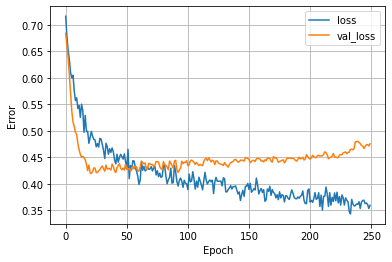

In [502]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 0.0050])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  #plt.yscale('log')
  plt.legend()
  plt.grid(True)
plot_loss(history)

Try some of them predictions

In [504]:
print(X_test.shape)
print(X_train.shape)
print(y_test.shape)
print(y_train.shape)
y_pred = ann.predict(X_test)
y_pred = (y_pred > 0.5)

#for i in np.arange(0,10,1):   
#    print((ann.predict(X_test)[i] ) , (y_test.iloc[i] ))
#    print((ann.predict(X_test)[i] > 0.5) , (y_test.iloc[i]> 0.5 ))



(90, 23)
(801, 23)
(90,)
(801,)


# Evaluating my shit (confusion matrix, roc curve, etc)

In [482]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)


[[104   6]
 [ 24  45]]


0.8324022346368715

Doesnt seem to be working that great, could be better

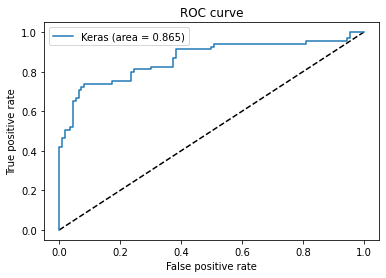

In [491]:
from sklearn.metrics import roc_curve
y_pred_keras = ann.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()